# 02: Probabilistic Regression Model with TFP

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
%matplotlib inline

## Make Dataset

### Design standard deviation $\sigma$

In [2]:
x_1 = np.linspace(1, 8, 100)
x_2 = np.repeat(8, 30)
x_3 = np.linspace(8, 1, 150)
x_4 = np.repeat(1, 60)
x_5 = np.linspace(1, 8, 120)
x_6 = np.linspace(8, 1, 200)
x_7 = np.repeat(1, 50)

In [3]:
x = np.concatenate([x_1, x_2, x_3, x_4, x_5, x_6, x_7])

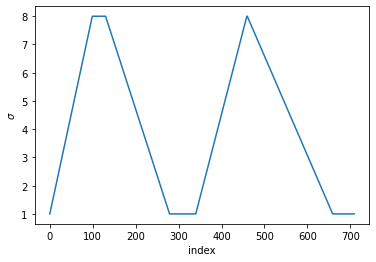

In [4]:
plt.plot(x)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.show()

In [5]:
x.shape

(710,)

### Generate samples based on $\sigma$

In [6]:
noise = np.random.normal(0, x, size=len(x))

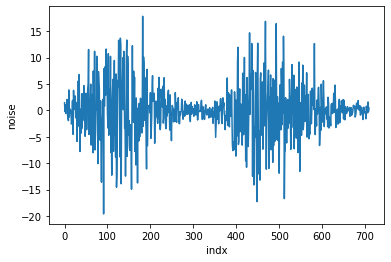

In [7]:
plt.plot(noise)
plt.xlabel("indx")
plt.ylabel("noise")
plt.show()

In [8]:
x_sample = np.sort(np.random.uniform(-3, 3, size=len(x)))

In [9]:
y_sample = 3.3 * x_sample + 3.0 + noise

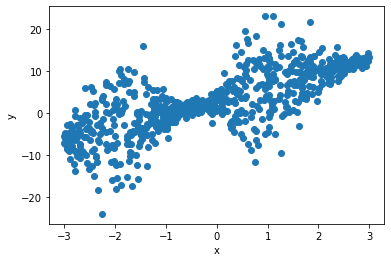

In [10]:
plt.scatter(x_sample, y_sample)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Split Train / Validation / Test dataset

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [12]:
order_idx_train = x_train.argsort(axis=0)

In [13]:
x_train = x_train[order_idx_train, np.newaxis]
y_train = y_train[order_idx_train, np.newaxis]
x_train.shape

(454, 1)

In [14]:
order_idx_val = x_val.argsort(axis=0)

In [15]:
x_val = x_val[order_idx_val, np.newaxis]
y_val = y_val[order_idx_val, np.newaxis]
x_val.shape

(114, 1)

In [16]:
order_idx_test = x_test.argsort(axis=0)

In [17]:
x_test = x_test[order_idx_test, np.newaxis]
y_test = y_test[order_idx_test, np.newaxis]

In [18]:
x_test.shape

(142, 1)

### Visualize Train, Validation, Test

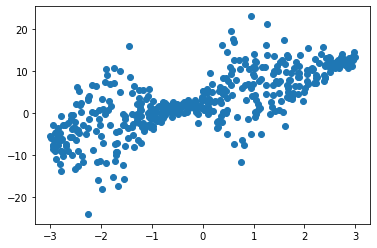

In [19]:
plt.scatter(x_train, y_train)

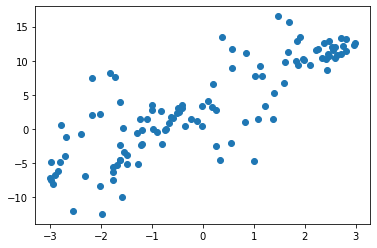

In [20]:
plt.scatter(x_val, y_val)

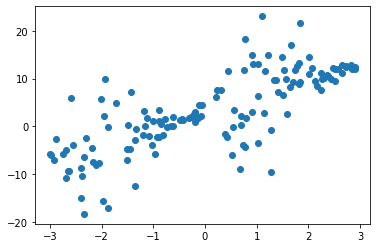

In [21]:
plt.scatter(x_test, y_test)

## Fitting and evaluating a linear regression model with constant variance

In [22]:
def NLL(y, distribution):
    return -distribution.log_prob(y)

def my_dist(params):
    return tfp.distributions.Normal(loc=params, scale=1)

inputs = Input(shape=(1,))
params = Dense(1)(inputs)
dist = tfp.layers.DistributionLambda(my_dist)(params)
model_sd_1 = Model(inputs=inputs, outputs=dist)
model_sd_1.compile(Adam(), loss=NLL)

In [23]:
model_sd_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model_sd_1.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val, y_val))

Let's check the training found the correct slope and intercept.

In [25]:
model_sd_1.get_weights()

[array([[3.141896]], dtype=float32), array([2.9407244], dtype=float32)]

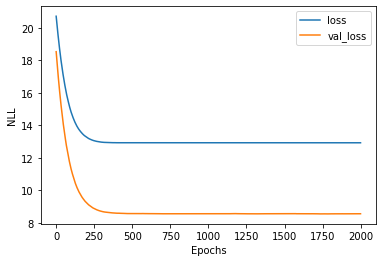

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [27]:
x_pred = np.arange(-3, 3, 0.1)
x_pred.shape

(60,)

In [28]:
preds = model_sd_1(x_pred).mean()

In [29]:
sigma = 1 # predefined

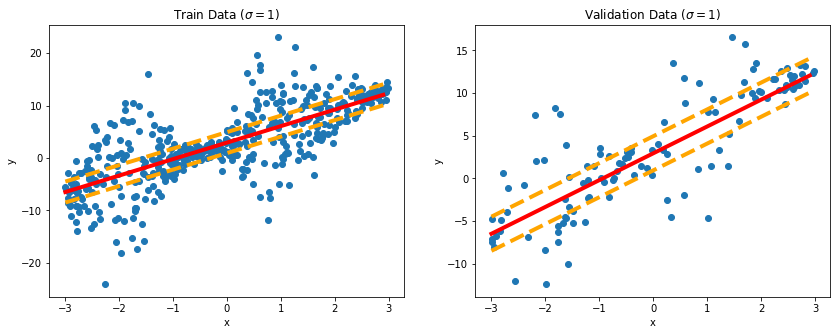

In [30]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train Data ($\sigma=1$)")

plt.subplot(1,2,2)
plt.scatter(x_val, y_val)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Validation Data ($\sigma=1$)")
plt.show()

## Performance (NLL)

In [31]:
model_sd_1.evaluate(x_train, y_train)

15/15 [==============================] - 0s 934us/step - loss: 12.9229


12.922921180725098

In [32]:
model_sd_1.evaluate(x_val, y_val)

4/4 [==============================] - 0s 2ms/step - loss: 8.5542


8.554190635681152

## How about using $\sigma=5$?

In [33]:
def NLL(y, distribution):
    return -distribution.log_prob(y)

def my_dist(params):
    return tfp.distributions.Normal(loc=params, scale=5)

inputs = Input(shape=(1,))
params = Dense(1)(inputs)
dist = tfp.layers.DistributionLambda(my_dist)(params)
model_sd_5 = Model(inputs=inputs, outputs=dist)
model_sd_5.compile(Adam(), loss=NLL)

In [34]:
history = model_sd_5.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val, y_val))

In [35]:
model_sd_5.get_weights()

[array([[3.1575468]], dtype=float32), array([2.9363136], dtype=float32)]

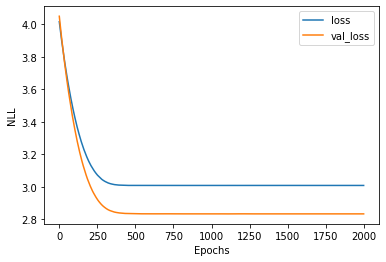

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [37]:
preds = model_sd_5(x_pred).mean()

In [38]:
sigma = 5 # predefined

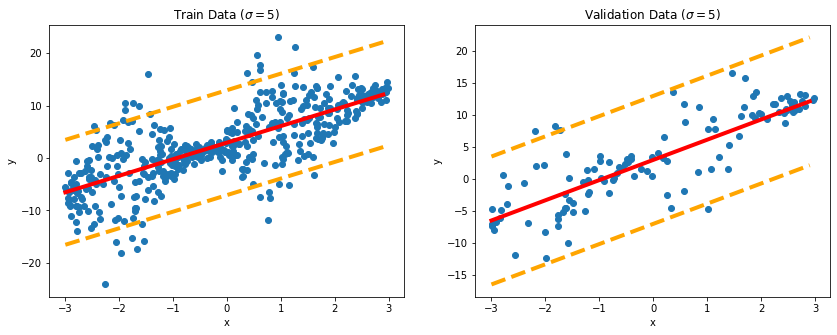

In [39]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train Data ($\sigma=5$)")

plt.subplot(1,2,2)
plt.scatter(x_val, y_val)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Validation Data ($\sigma=5$)")
plt.show()

In [40]:
model_sd_5.evaluate(x_train, y_train)

15/15 [==============================] - 0s 821us/step - loss: 3.0085


3.0085251331329346

In [41]:
model_sd_5.evaluate(x_val, y_val)

4/4 [==============================] - 0s 1ms/step - loss: 2.8337


2.833737373352051

## Fitting and evaluating a linear regression model with a nonconstant variance

In [42]:
def NLL(y, distribution):
    return -distribution.log_prob(y)

def my_dist(params):
    return tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
params = Dense(2)(inputs)
dist = tfp.layers.DistributionLambda(my_dist)(params)
model_monotonic_sd = Model(inputs=inputs, outputs=dist)
model_monotonic_sd.compile(Adam(), loss=NLL)

In [43]:
model_monotonic_sd.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_2 (Distr multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model_monotonic_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

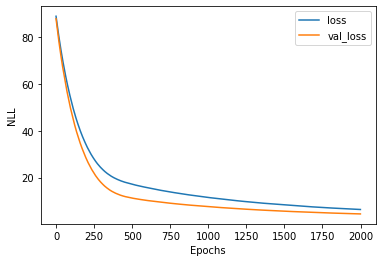

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [46]:
print(model_monotonic_sd.evaluate(x_train,y_train, verbose=0))
print(model_monotonic_sd.evaluate(x_val,y_val, verbose=0))

6.410869121551514
4.525267601013184


In [47]:
preds = model_monotonic_sd(x_pred).mean()
sigma = model_monotonic_sd(x_pred).stddev()

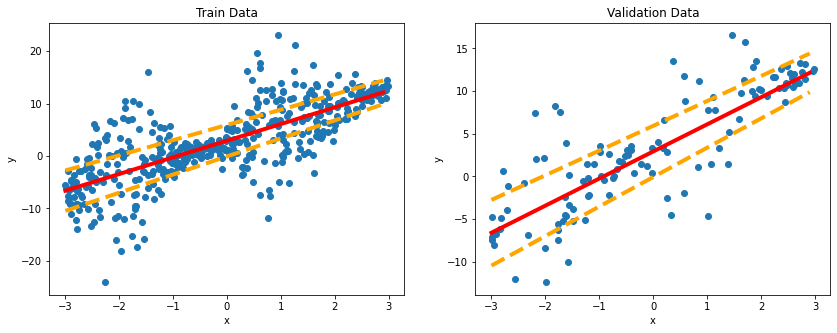

In [48]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train Data")

plt.subplot(1,2,2)
plt.scatter(x_val, y_val)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Validation Data")
plt.show()

### Give more flexibility for standard deviation

In [49]:
def NLL(y, distr):
    return -distr.log_prob(y) 

def my_dist(params):
    return tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
out1 = Dense(1)(inputs)
hidden1 = Dense(30,activation="relu")(inputs)
hidden2 = Dense(20,activation="relu")(hidden1)
hidden3 = Dense(20,activation="relu")(hidden2)
out2 = Dense(1)(hidden3)
params = Concatenate()([out1,out2])
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(learning_rate=0.01), loss=NLL)

In [50]:
model_flex_sd.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           60          input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 20)           620         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 20)           420         dense_5[0][0]                    
____________________________________________________________________________________________

In [51]:
history = model_flex_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In [52]:
preds = model_flex_sd(x_pred).mean()
sigma = model_flex_sd(x_pred).stddev()

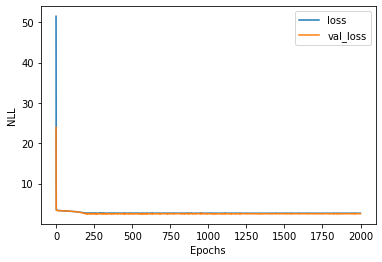

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [54]:
print(model_flex_sd.evaluate(x_train,y_train, verbose=0))
print(model_flex_sd.evaluate(x_val,y_val, verbose=0))

2.618448495864868
2.4858360290527344


In [55]:
preds = model_flex_sd(x_pred).mean()
sigma = model_flex_sd(x_pred).stddev()

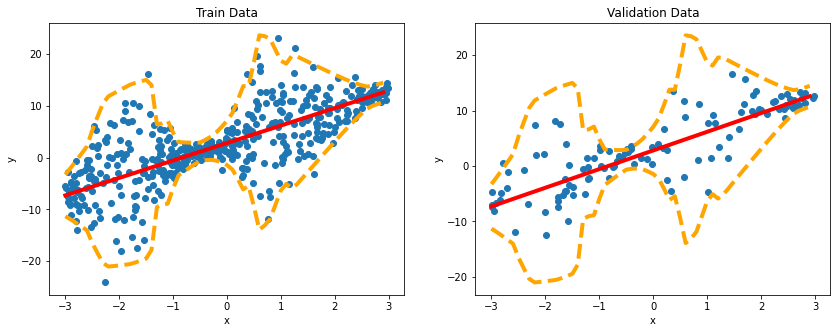

In [56]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train Data")

plt.subplot(1,2,2)
plt.scatter(x_val, y_val)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Validation Data")
plt.show()

## Test the model on test data

**Make sure that training and test data shape is a matrix, not a vector.**

In [57]:
model_flex_sd.evaluate(x_test, y_test, verbose=0)

2.6366796493530273

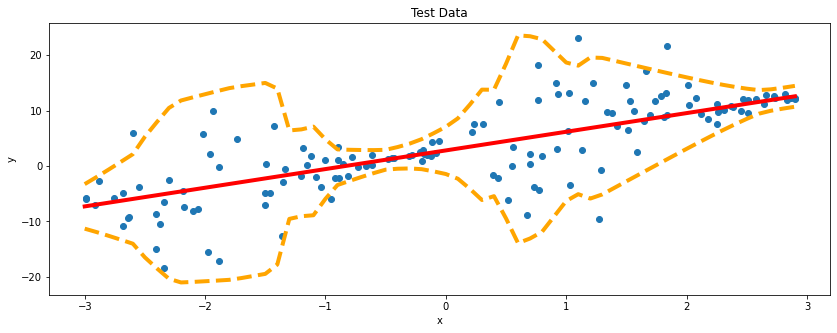

In [58]:
plt.figure(figsize=(14, 5))
plt.scatter(x_test, y_test)
plt.plot(x_pred, preds, color="red", linewidth=4)
plt.plot(x_pred, preds + 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.plot(x_pred, preds - 2*sigma, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test Data")
plt.show()

In [59]:
-np.mean(model_flex_sd(x_test).log_prob(y_test))

2.6366794

In [60]:
NLL_test = np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(model_flex_sd(x_test).stddev()))))+
                 ((np.square(y_test-model_flex_sd(x_test).mean())/(2*np.square(model_flex_sd(x_test).stddev())))))
print(NLL_test)

2.6366794


## Test it on outside the observed data region (extrapolation)

Text(0.5, 1.0, 'Test Data (with extrapolation)')

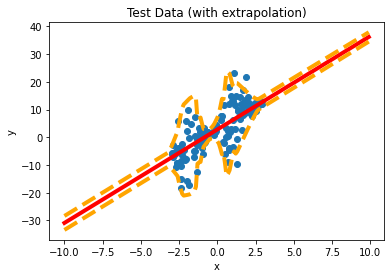

In [95]:
x_extp = np.arange(-10, 10, 0.1)
preds_extp = model_flex_sd(x_extp).mean()
sigma_extp = model_flex_sd(x_extp).stddev()

plt.scatter(x_test, y_test)
plt.plot(x_extp, preds_extp, color="red", linewidth=4)
plt.plot(x_extp, preds_extp + 2*sigma_extp, color="orange", linestyle="--", linewidth=4)
plt.plot(x_extp, preds_extp - 2*sigma_extp, color="orange", linestyle="--", linewidth=4)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test Data (with extrapolation)")